In [1]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import scipy.stats as stats
import itertools

In [2]:
# Load SAFE stock dataset
df_safe = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='SAFE.JK')
df_safe.set_index('Date', drop=True, inplace=True)
df_safe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0
2011-04-04,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0
2011-04-05,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0
2011-04-06,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0
2011-04-07,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0


In [3]:
# Check datatypes
print(df_safe.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [4]:
# Check missing value
print(df_safe.isnull().sum())

Open         8
High         8
Low          8
Close        8
Adj Close    8
Volume       8
dtype: int64


In [5]:
# Fill missing value using mean imputation
for i in df_safe[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
    df_safe[i].fillna(df_safe[i].mean(), inplace=True)

print(df_safe.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


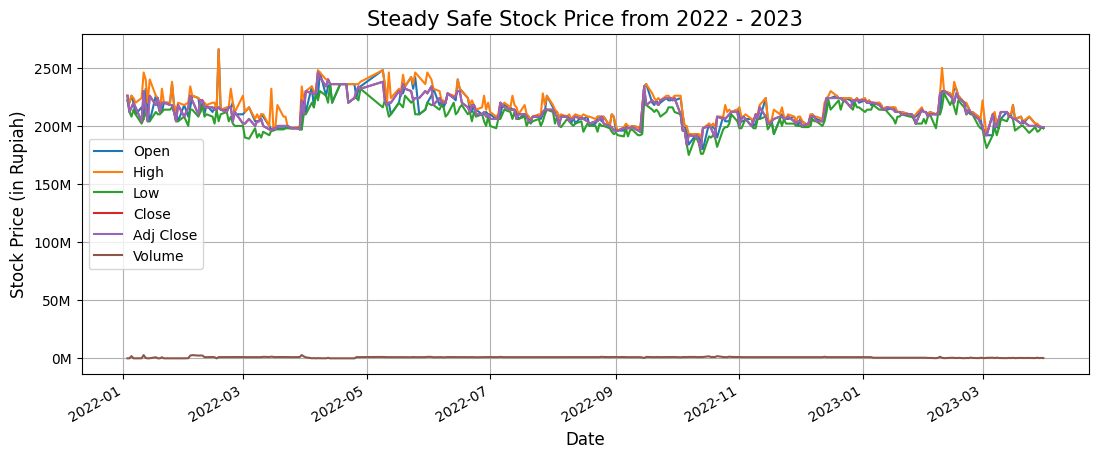

In [6]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_safe['2022':].plot(figsize=(13,5))
plt.title('Steady Safe Stock Price from 2022 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

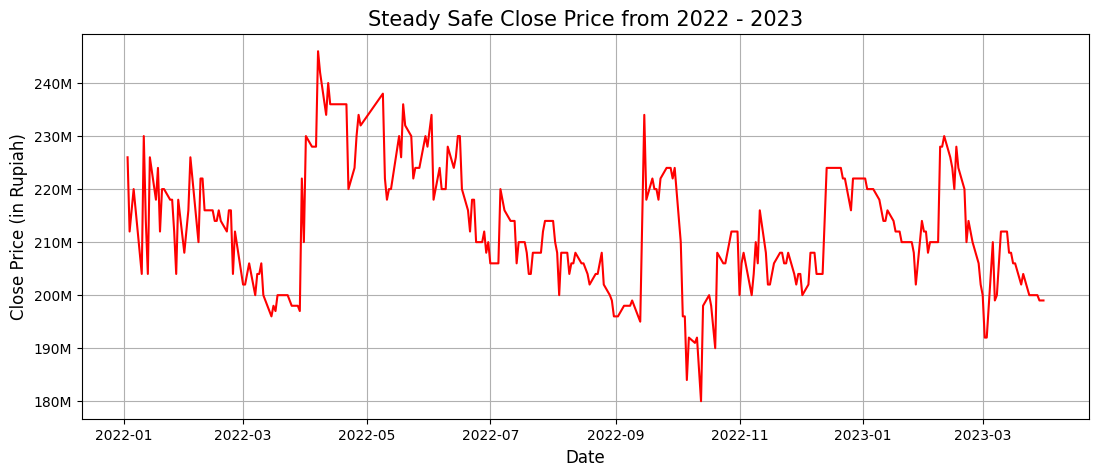

In [7]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize each of price attributes
plt.figure(figsize=(13,5))
plt.plot(df_safe['Close']['2022':], color='red')
plt.title('Steady Safe Close Price from 2022 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [8]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_safe[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [9]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.12535613]
 [0.12535613]
 [0.12535613]
 [0.12535613]
 [0.12535613]] 

Testing Scaled:  [[0.41880342]
 [0.43589744]
 [0.4017094 ]
 [0.42450142]
 [0.42450142]]


In [10]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


##### LSTM Network Default Model

In [11]:
# define the model
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
model.fit(X_train, y_train, epochs=10, 
          batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 5s 57ms/step - loss: 0.0064 - val_loss: 0.0029
Epoch 2/10
24/24 [==============================] - 1s 23ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 3/10
24/24 [==============================] - 1s 24ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 4/10
24/24 [==============================] - 1s 24ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 5/10
24/24 [==============================] - 1s 24ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 6/10
24/24 [==============================] - 1s 24ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 7/10
24/24 [==============================] - 1s 25ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 8/10
24/24 [==============================] - 1s 25ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 9/10
24/24 [==============================] - 1s 25ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 10/10
24/24 [==============================] - 1s 28ms/step - loss: 0.0013 - val_loss: 0.0022
Model: "s

In [12]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 1s 9ms/step
Mean Absolute Percentage Error (MAPE):  0.03994
Mean Absolute Error (MAE):  0.0161622
Mean Squared Error (MSE):  0.0004773
Root Mean Squared Error (RMSE):  0.02185
R-Squared:  0.526685


8/8 [==============================] - 0s 7ms/step


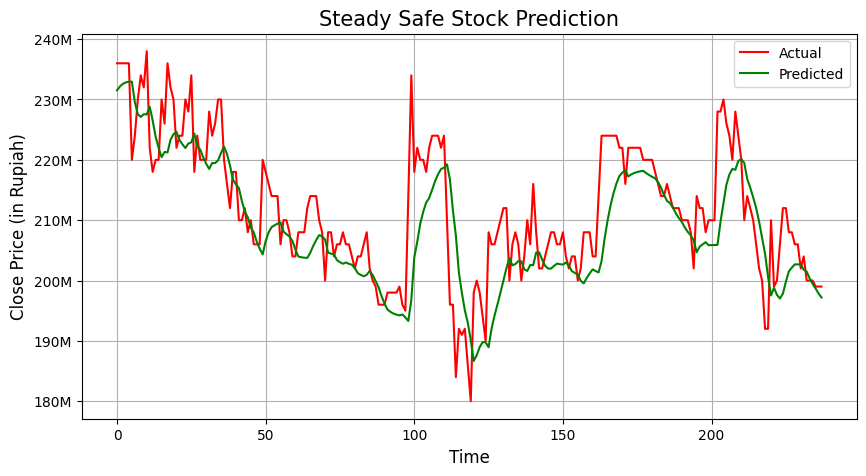

In [13]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

# Save the default model
model.save('models/safe_lstm_default.h5')

##### Linear - Adam

In [14]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 284ms/step - loss: 0.0145 - val_loss: 0.0031
Epoch 2/10
24/24 [==============================] - 5s 222ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 3/10
24/24 [==============================] - 6s 249ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 4/10
24/24 [==============================] - 6s 232ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 5/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 6s 246ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 6s 231ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 6s 236ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 9/10
24/24 [==============================] - 7s 289ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 10/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0017 - val_loss: 0.002

In [15]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 32ms/step
Mean Absolute Percentage Error (MAPE):  0.03891
Mean Absolute Error (MAE):  0.0156252
Mean Squared Error (MSE):  0.0004906
Root Mean Squared Error (RMSE):  0.02215
R-Squared:  0.513455


8/8 [==============================] - 0s 33ms/step


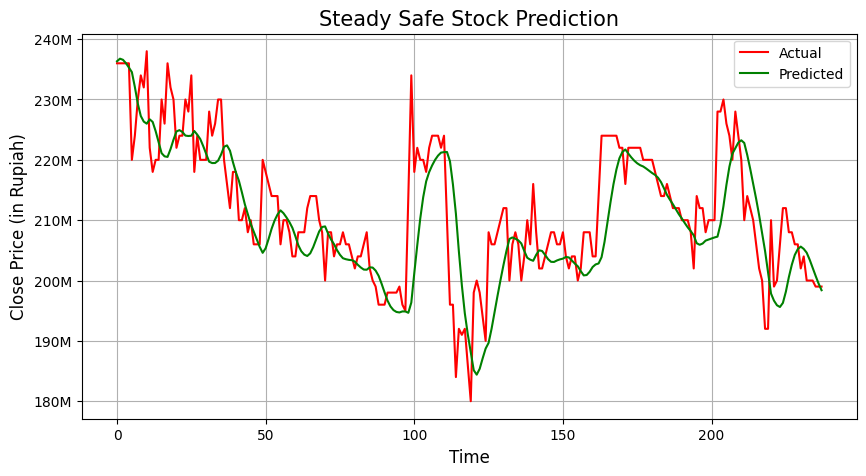

In [16]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

# Save the default model
model.save('models/safe_linear_adam.h5')

##### Linear - AdaGrad

In [17]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 436ms/step - loss: 0.0515 - val_loss: 0.0344
Epoch 2/10
24/24 [==============================] - 7s 304ms/step - loss: 0.0306 - val_loss: 0.0185
Epoch 3/10
24/24 [==============================] - 7s 299ms/step - loss: 0.0257 - val_loss: 0.0142
Epoch 4/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0231 - val_loss: 0.0125
Epoch 5/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0215 - val_loss: 0.0109
Epoch 6/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0192 - val_loss: 0.0101
Epoch 7/10
24/24 [==============================] - 6s 266ms/step - loss: 0.0181 - val_loss: 0.0092
Epoch 8/10
24/24 [==============================] - 7s 310ms/step - loss: 0.0160 - val_loss: 0.0086
Epoch 9/10
24/24 [==============================] - 7s 300ms/step - loss: 0.0149 - val_loss: 0.0080
Epoch 10/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0136 - val_loss: 0.007

In [18]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 38ms/step
Mean Absolute Percentage Error (MAPE):  0.17471
Mean Absolute Error (MAE):  0.0716073
Mean Squared Error (MSE):  0.0057952
Root Mean Squared Error (RMSE):  0.07613
R-Squared:  -4.747317


8/8 [==============================] - 0s 33ms/step


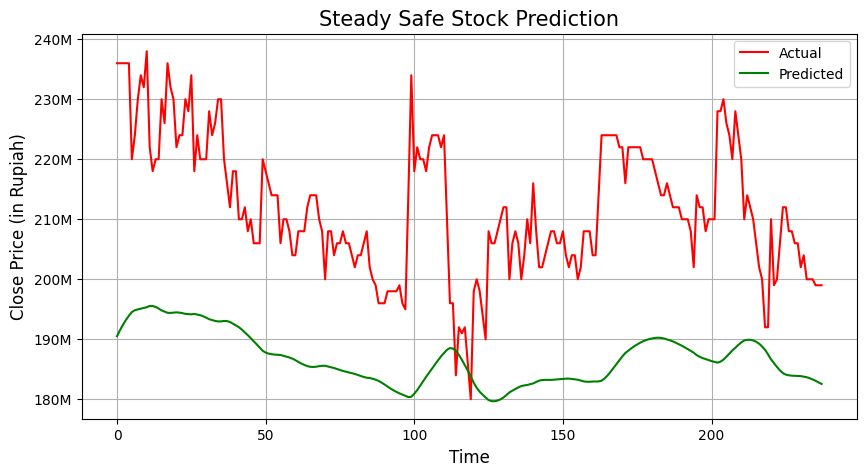

In [19]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_linear_adagrad.h5')

##### Linear - Nadam

In [20]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 304ms/step - loss: 0.0152 - val_loss: 0.0032
Epoch 2/10
24/24 [==============================] - 5s 215ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 3/10
24/24 [==============================] - 5s 210ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 4/10
24/24 [==============================] - 5s 218ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 5/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 6s 238ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 7/10
24/24 [==============================] - 6s 236ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 5s 224ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 5s 228ms/step - loss: 0.0018 - val_loss: 0.0027
Epoch 10/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0018 - val_loss: 0.002

In [21]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 32ms/step
Mean Absolute Percentage Error (MAPE):  0.05133
Mean Absolute Error (MAE):  0.0208461
Mean Squared Error (MSE):  0.0007185
Root Mean Squared Error (RMSE):  0.0268
R-Squared:  0.287424


8/8 [==============================] - 0s 38ms/step


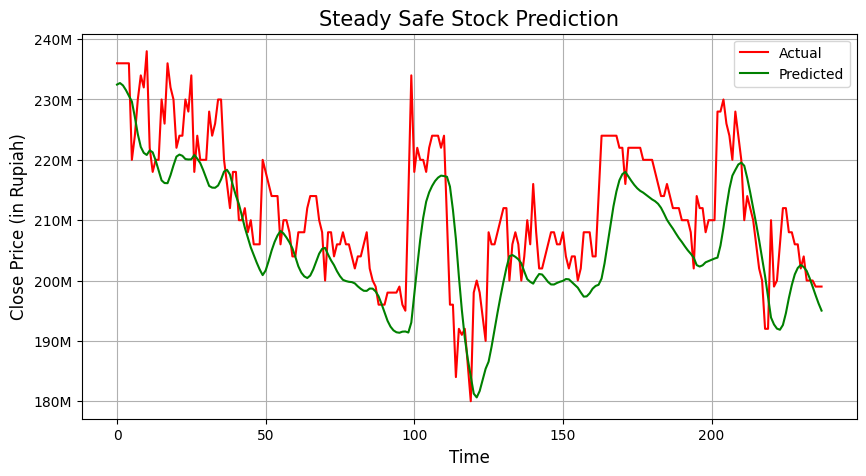

In [22]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_linear_nadam.h5')

#### Linear - RMSProp

In [23]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 15s 357ms/step - loss: 0.0134 - val_loss: 0.0074
Epoch 2/10
24/24 [==============================] - 6s 243ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 3/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0036 - val_loss: 0.0068
Epoch 4/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 6s 244ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 6/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 7/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 8/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 7s 284ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 10/10
24/24 [==============================] - 7s 308ms/step - loss: 0.0024 - val_loss: 0.002

In [24]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 35ms/step
Mean Absolute Percentage Error (MAPE):  0.04072
Mean Absolute Error (MAE):  0.0161813
Mean Squared Error (MSE):  0.0005173
Root Mean Squared Error (RMSE):  0.02274
R-Squared:  0.486999


8/8 [==============================] - 0s 37ms/step


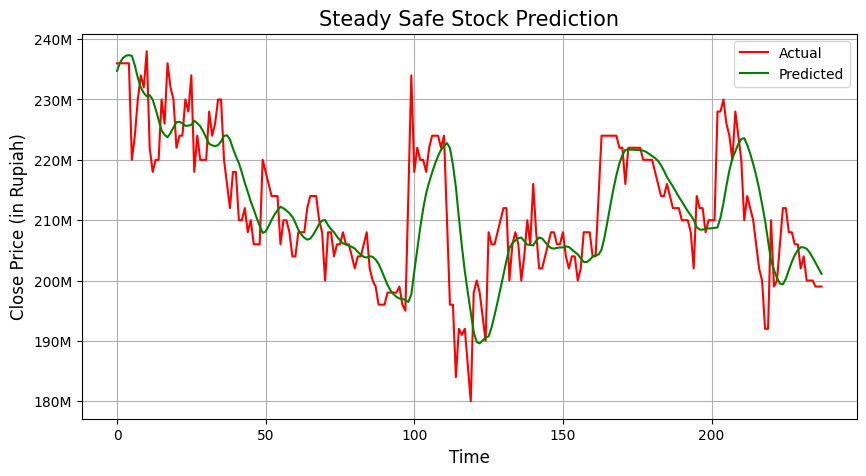

In [25]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_linear_rmsprop.h5')

##### Linear - AdaDelta

In [26]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 16s 343ms/step - loss: 0.0898 - val_loss: 0.1312
Epoch 2/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0883 - val_loss: 0.1286
Epoch 3/10
24/24 [==============================] - 7s 271ms/step - loss: 0.0863 - val_loss: 0.1260
Epoch 4/10
24/24 [==============================] - 6s 255ms/step - loss: 0.0843 - val_loss: 0.1234
Epoch 5/10
24/24 [==============================] - 6s 259ms/step - loss: 0.0826 - val_loss: 0.1208
Epoch 6/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0812 - val_loss: 0.1182
Epoch 7/10
24/24 [==============================] - 8s 346ms/step - loss: 0.0799 - val_loss: 0.1156
Epoch 8/10
24/24 [==============================] - 7s 272ms/step - loss: 0.0777 - val_loss: 0.1130
Epoch 9/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0758 - val_loss: 0.1104
Epoch 10/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0737 - val_loss: 0.107

In [27]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 36ms/step
Mean Absolute Percentage Error (MAPE):  0.85847
Mean Absolute Error (MAE):  0.3448746
Mean Squared Error (MSE):  0.1198468
Root Mean Squared Error (RMSE):  0.34619
R-Squared:  -117.855756


8/8 [==============================] - 0s 36ms/step


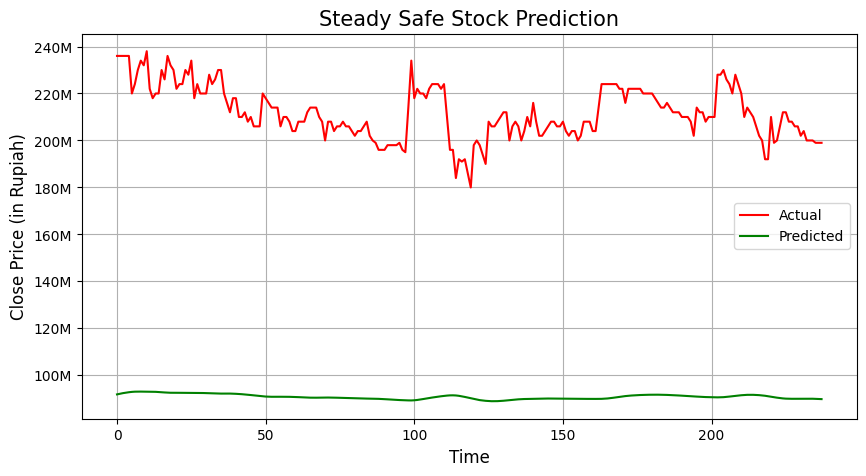

In [28]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_linear_adadelta.h5')

##### Linear - SGD

In [29]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 15s 356ms/step - loss: 0.0437 - val_loss: 0.0219
Epoch 2/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0300 - val_loss: 0.0168
Epoch 3/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0273 - val_loss: 0.0146
Epoch 4/10
24/24 [==============================] - 7s 287ms/step - loss: 0.0248 - val_loss: 0.0138
Epoch 5/10
24/24 [==============================] - 7s 285ms/step - loss: 0.0220 - val_loss: 0.0125
Epoch 6/10
24/24 [==============================] - 7s 271ms/step - loss: 0.0197 - val_loss: 0.0112
Epoch 7/10
24/24 [==============================] - 6s 271ms/step - loss: 0.0169 - val_loss: 0.0093
Epoch 8/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0149 - val_loss: 0.0079
Epoch 9/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0128 - val_loss: 0.0079
Epoch 10/10
24/24 [==============================] - 7s 285ms/step - loss: 0.0109 - val_loss: 0.006

In [30]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 38ms/step
Mean Absolute Percentage Error (MAPE):  0.16363
Mean Absolute Error (MAE):  0.0670734
Mean Squared Error (MSE):  0.0051203
Root Mean Squared Error (RMSE):  0.07156
R-Squared:  -4.078002


8/8 [==============================] - 0s 39ms/step


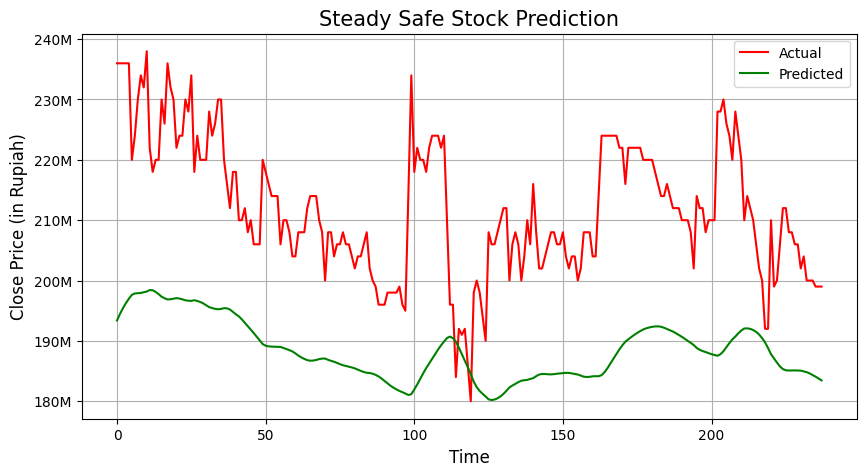

In [31]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_linear_sgd.h5')

#### Linear - Adamax

In [32]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 448ms/step - loss: 0.0112 - val_loss: 0.0036
Epoch 2/10
24/24 [==============================] - 7s 271ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 3/10
24/24 [==============================] - 7s 285ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 7s 294ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 6/10
24/24 [==============================] - 6s 266ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 7/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 8/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 10/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0025 - val_loss: 0.002

In [33]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 44ms/step
Mean Absolute Percentage Error (MAPE):  0.04459
Mean Absolute Error (MAE):  0.017689
Mean Squared Error (MSE):  0.0005914
Root Mean Squared Error (RMSE):  0.02432
R-Squared:  0.413497


8/8 [==============================] - 0s 42ms/step


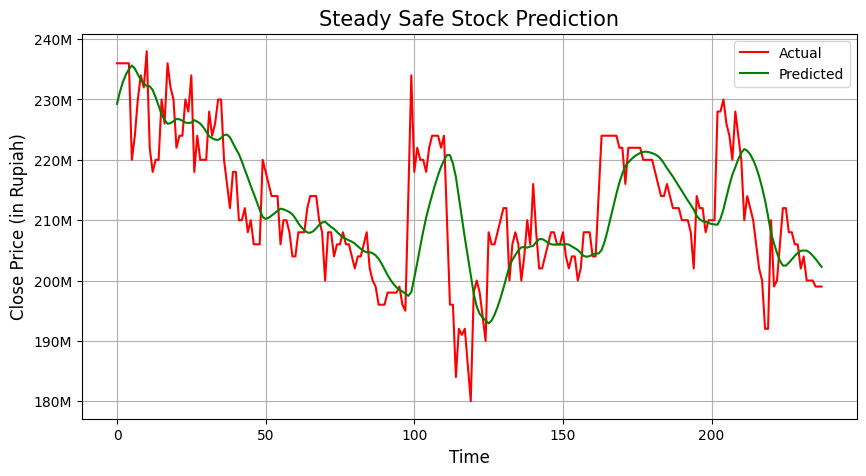

In [34]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_linear_adamax.h5')

##### ReLU - Adam

In [35]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 15s 300ms/step - loss: 0.0151 - val_loss: 0.0043
Epoch 2/10
24/24 [==============================] - 8s 315ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 3/10
24/24 [==============================] - 8s 323ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 4/10
24/24 [==============================] - 8s 338ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 5/10
24/24 [==============================] - 8s 333ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 8s 321ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 7/10
24/24 [==============================] - 8s 343ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 8s 325ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 8s 318ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 10/10
24/24 [==============================] - 8s 323ms/step - loss: 0.0019 - val_loss: 0.002

In [36]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 39ms/step
Mean Absolute Percentage Error (MAPE):  0.03928
Mean Absolute Error (MAE):  0.0156348
Mean Squared Error (MSE):  0.0004855
Root Mean Squared Error (RMSE):  0.02203
R-Squared:  0.518498


8/8 [==============================] - 0s 40ms/step


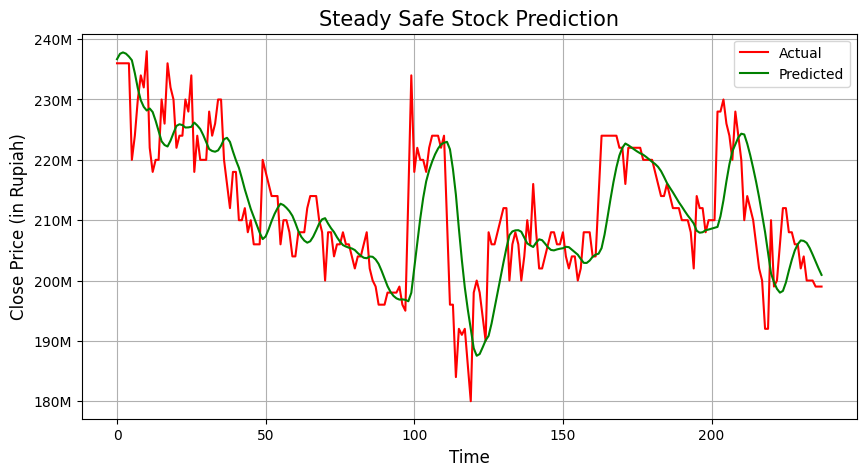

In [37]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_relu_adam.h5')

#### ReLU - AdaGrad

In [38]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 14s 318ms/step - loss: 0.0746 - val_loss: 0.0836
Epoch 2/10
24/24 [==============================] - 5s 199ms/step - loss: 0.0540 - val_loss: 0.0591
Epoch 3/10
24/24 [==============================] - 5s 202ms/step - loss: 0.0432 - val_loss: 0.0436
Epoch 4/10
24/24 [==============================] - 5s 205ms/step - loss: 0.0368 - val_loss: 0.0337
Epoch 5/10
24/24 [==============================] - 5s 226ms/step - loss: 0.0337 - val_loss: 0.0273
Epoch 6/10
24/24 [==============================] - 5s 226ms/step - loss: 0.0309 - val_loss: 0.0229
Epoch 7/10
24/24 [==============================] - 5s 226ms/step - loss: 0.0293 - val_loss: 0.0199
Epoch 8/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0283 - val_loss: 0.0179
Epoch 9/10
24/24 [==============================] - 5s 214ms/step - loss: 0.0271 - val_loss: 0.0163
Epoch 10/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0258 - val_loss: 0.015

In [39]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 38ms/step
Mean Absolute Percentage Error (MAPE):  0.30224
Mean Absolute Error (MAE):  0.1228089
Mean Squared Error (MSE):  0.0158896
Root Mean Squared Error (RMSE):  0.12605
R-Squared:  -14.758219


8/8 [==============================] - 0s 39ms/step


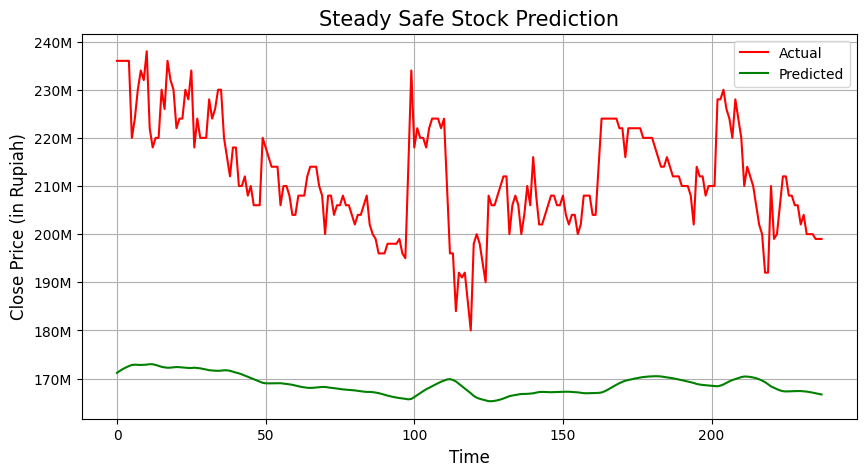

In [40]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_relu_adagrad.h5')

##### ReLU - Nadam

In [41]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 19s 342ms/step - loss: 0.0180 - val_loss: 0.0032
Epoch 2/10
24/24 [==============================] - 8s 335ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 3/10
24/24 [==============================] - 9s 371ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 8s 346ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 5/10
24/24 [==============================] - 8s 346ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 6/10
24/24 [==============================] - 8s 340ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 7/10
24/24 [==============================] - 8s 332ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 8s 338ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 9/10
24/24 [==============================] - 8s 328ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 10/10
24/24 [==============================] - 8s 346ms/step - loss: 0.0019 - val_loss: 0.003

In [42]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 4s 61ms/step
Mean Absolute Percentage Error (MAPE):  0.07615
Mean Absolute Error (MAE):  0.0310016
Mean Squared Error (MSE):  0.0013103
Root Mean Squared Error (RMSE):  0.0362
R-Squared:  -0.29943


8/8 [==============================] - 0s 43ms/step


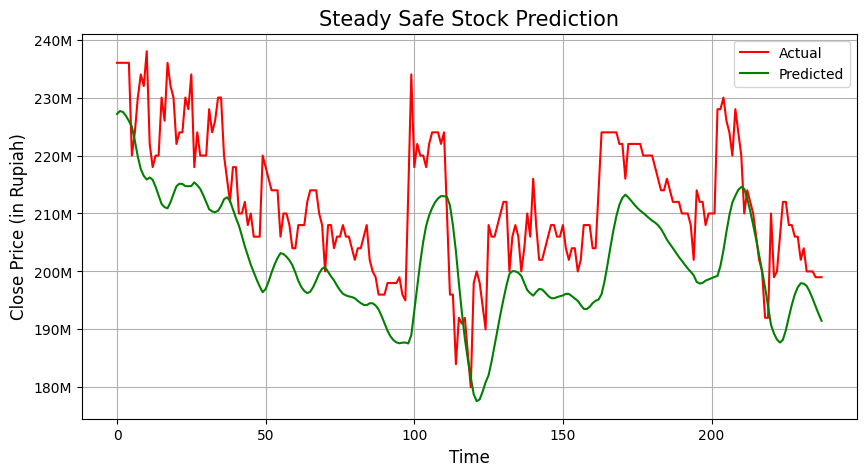

In [43]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_relu_nadam.h5')

##### ReLU - RMSProp

In [44]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 484ms/step - loss: 0.0116 - val_loss: 0.0050
Epoch 2/10
24/24 [==============================] - 17s 721ms/step - loss: 0.0045 - val_loss: 0.0030
Epoch 3/10
24/24 [==============================] - 18s 772ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 4/10
24/24 [==============================] - 18s 768ms/step - loss: 0.0034 - val_loss: 0.0053
Epoch 5/10
24/24 [==============================] - 18s 745ms/step - loss: 0.0031 - val_loss: 0.0073
Epoch 6/10
24/24 [==============================] - 18s 752ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 7/10
24/24 [==============================] - 19s 796ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 17s 717ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 9/10
24/24 [==============================] - 16s 682ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 10/10
24/24 [==============================] - 17s 703ms/step - loss: 0.0026 - val_lo

In [45]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 63ms/step
Mean Absolute Percentage Error (MAPE):  0.04269
Mean Absolute Error (MAE):  0.0168577
Mean Squared Error (MSE):  0.000538
Root Mean Squared Error (RMSE):  0.02319
R-Squared:  0.466472


8/8 [==============================] - 1s 73ms/step


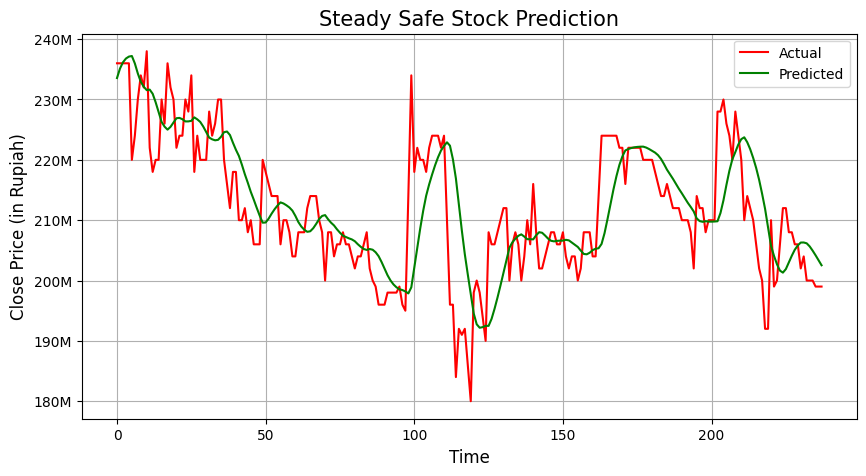

In [46]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_relu_rmsprop.h5')

##### ReLU - AdaDelta

In [47]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 17s 383ms/step - loss: 0.0805 - val_loss: 0.1174
Epoch 2/10
24/24 [==============================] - 9s 361ms/step - loss: 0.0790 - val_loss: 0.1155
Epoch 3/10
24/24 [==============================] - 9s 365ms/step - loss: 0.0776 - val_loss: 0.1136
Epoch 4/10
24/24 [==============================] - 9s 360ms/step - loss: 0.0763 - val_loss: 0.1117
Epoch 5/10
24/24 [==============================] - 8s 350ms/step - loss: 0.0747 - val_loss: 0.1098
Epoch 6/10
24/24 [==============================] - 8s 352ms/step - loss: 0.0741 - val_loss: 0.1079
Epoch 7/10
24/24 [==============================] - 9s 392ms/step - loss: 0.0723 - val_loss: 0.1060
Epoch 8/10
24/24 [==============================] - 8s 352ms/step - loss: 0.0715 - val_loss: 0.1041
Epoch 9/10
24/24 [==============================] - 8s 353ms/step - loss: 0.0699 - val_loss: 0.1021
Epoch 10/10
24/24 [==============================] - 9s 372ms/step - loss: 0.0685 - val_loss: 0.100

In [48]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Percentage Error (MAPE):  0.82563
Mean Absolute Error (MAE):  0.3317285
Mean Squared Error (MSE):  0.1109206
Root Mean Squared Error (RMSE):  0.33305
R-Squared:  -109.003445


8/8 [==============================] - 0s 42ms/step


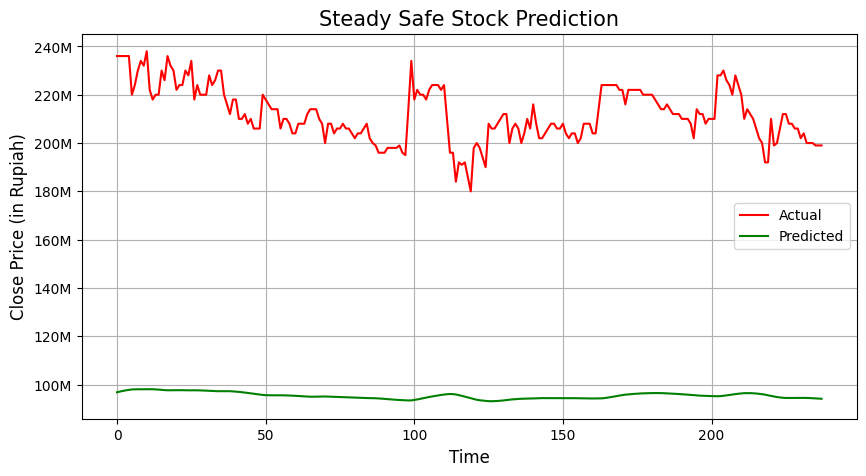

In [49]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_relu_adadelta.h5')

##### ReLU - SGD

In [50]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 16s 382ms/step - loss: 0.0554 - val_loss: 0.0295
Epoch 2/10
24/24 [==============================] - 10s 433ms/step - loss: 0.0341 - val_loss: 0.0183
Epoch 3/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0309 - val_loss: 0.0164
Epoch 4/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0286 - val_loss: 0.0151
Epoch 5/10
24/24 [==============================] - 11s 445ms/step - loss: 0.0262 - val_loss: 0.0140
Epoch 6/10
24/24 [==============================] - 11s 452ms/step - loss: 0.0237 - val_loss: 0.0129
Epoch 7/10
24/24 [==============================] - 11s 467ms/step - loss: 0.0214 - val_loss: 0.0128
Epoch 8/10
24/24 [==============================] - 11s 450ms/step - loss: 0.0189 - val_loss: 0.0113
Epoch 9/10
24/24 [==============================] - 11s 455ms/step - loss: 0.0172 - val_loss: 0.0094
Epoch 10/10
24/24 [==============================] - 11s 445ms/step - loss: 0.0144 - val_lo

In [51]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Percentage Error (MAPE):  0.1976
Mean Absolute Error (MAE):  0.0808238
Mean Squared Error (MSE):  0.0072326
Root Mean Squared Error (RMSE):  0.08504
R-Squared:  -6.172833


8/8 [==============================] - 0s 47ms/step


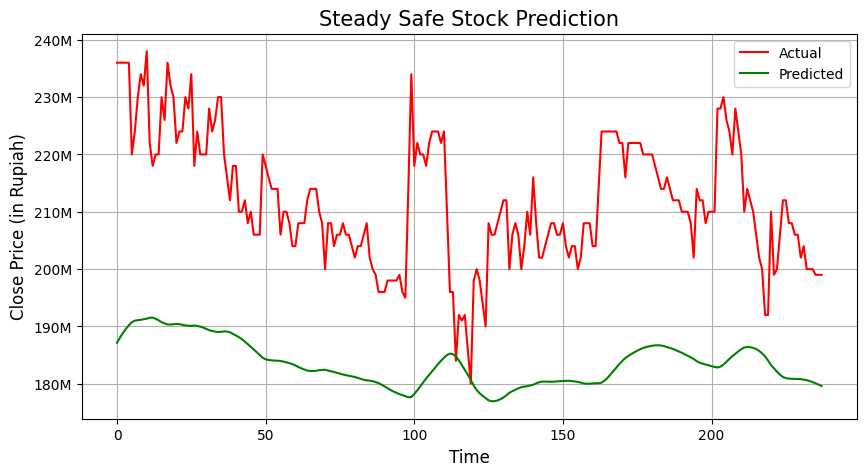

In [52]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_relu_sgd.h5')

##### ReLU - Adamax

In [53]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 23s 592ms/step - loss: 0.0172 - val_loss: 0.0030
Epoch 2/10
24/24 [==============================] - 12s 491ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 3/10
24/24 [==============================] - 12s 484ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 11s 446ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/10
24/24 [==============================] - 11s 444ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/10
24/24 [==============================] - 11s 446ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/10
24/24 [==============================] - 11s 450ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/10
24/24 [==============================] - 11s 475ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 9/10
24/24 [==============================] - 11s 472ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 10/10
24/24 [==============================] - 11s 466ms/step - loss: 0.0026 - val_lo

In [54]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 55ms/step
Mean Absolute Percentage Error (MAPE):  0.04814
Mean Absolute Error (MAE):  0.0194401
Mean Squared Error (MSE):  0.0007072
Root Mean Squared Error (RMSE):  0.02659
R-Squared:  0.29866


8/8 [==============================] - 0s 51ms/step


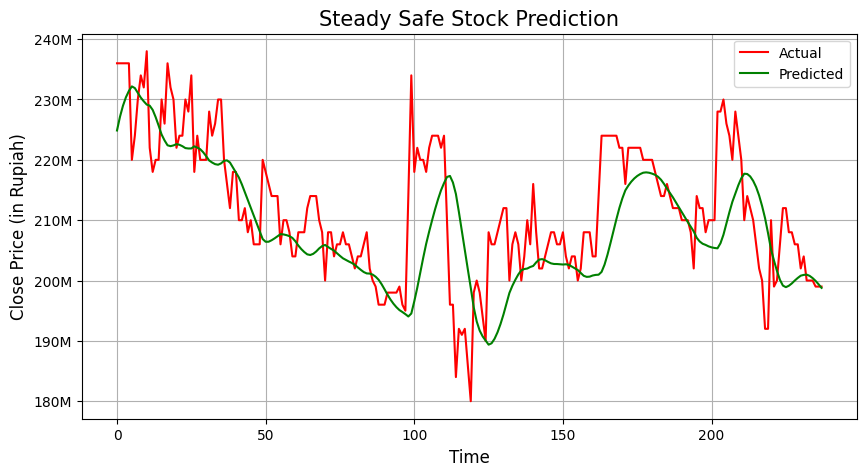

In [55]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_relu_adamax.h5')

##### Sigmoid - Adam

In [56]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 494ms/step - loss: 0.2031 - val_loss: 0.0426
Epoch 2/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0464 - val_loss: 0.0289
Epoch 3/10
24/24 [==============================] - 11s 455ms/step - loss: 0.0356 - val_loss: 0.0133
Epoch 4/10
24/24 [==============================] - 11s 441ms/step - loss: 0.0145 - val_loss: 0.0033
Epoch 5/10
24/24 [==============================] - 10s 435ms/step - loss: 0.0088 - val_loss: 0.0047
Epoch 6/10
24/24 [==============================] - 11s 459ms/step - loss: 0.0068 - val_loss: 0.0032
Epoch 7/10
24/24 [==============================] - 11s 471ms/step - loss: 0.0067 - val_loss: 0.0032
Epoch 8/10
24/24 [==============================] - 11s 459ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 9/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0051 - val_loss: 0.0057
Epoch 10/10
24/24 [==============================] - 11s 450ms/step - loss: 0.0044 - val_lo

In [57]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 47ms/step
Mean Absolute Percentage Error (MAPE):  0.07647
Mean Absolute Error (MAE):  0.0311204
Mean Squared Error (MSE):  0.0014197
Root Mean Squared Error (RMSE):  0.03768
R-Squared:  -0.407963


8/8 [==============================] - 0s 46ms/step


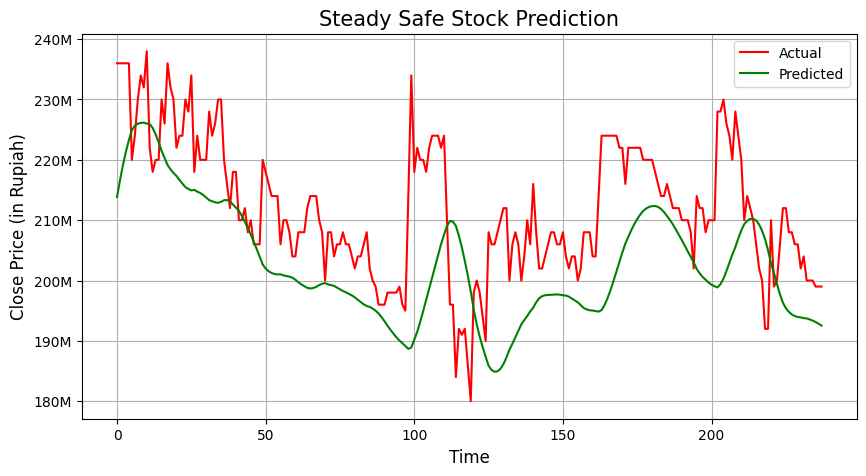

In [58]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_sigmoid_adam.h5')

##### Sigmoid - AdaGrad

In [59]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 19s 519ms/step - loss: 0.1944 - val_loss: 0.2173
Epoch 2/10
24/24 [==============================] - 11s 441ms/step - loss: 0.1264 - val_loss: 0.1582
Epoch 3/10
24/24 [==============================] - 11s 465ms/step - loss: 0.0946 - val_loss: 0.1221
Epoch 4/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0755 - val_loss: 0.0977
Epoch 5/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0629 - val_loss: 0.0802
Epoch 6/10
24/24 [==============================] - 11s 446ms/step - loss: 0.0546 - val_loss: 0.0672
Epoch 7/10
24/24 [==============================] - 11s 472ms/step - loss: 0.0487 - val_loss: 0.0574
Epoch 8/10
24/24 [==============================] - 11s 459ms/step - loss: 0.0446 - val_loss: 0.0499
Epoch 9/10
24/24 [==============================] - 13s 539ms/step - loss: 0.0419 - val_loss: 0.0440
Epoch 10/10
24/24 [==============================] - 12s 481ms/step - loss: 0.0396 - val_lo

In [60]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 47ms/step
Mean Absolute Percentage Error (MAPE):  0.5205
Mean Absolute Error (MAE):  0.2100773
Mean Squared Error (MSE):  0.0450687
Root Mean Squared Error (RMSE):  0.21229
R-Squared:  -43.696039


8/8 [==============================] - 0s 49ms/step


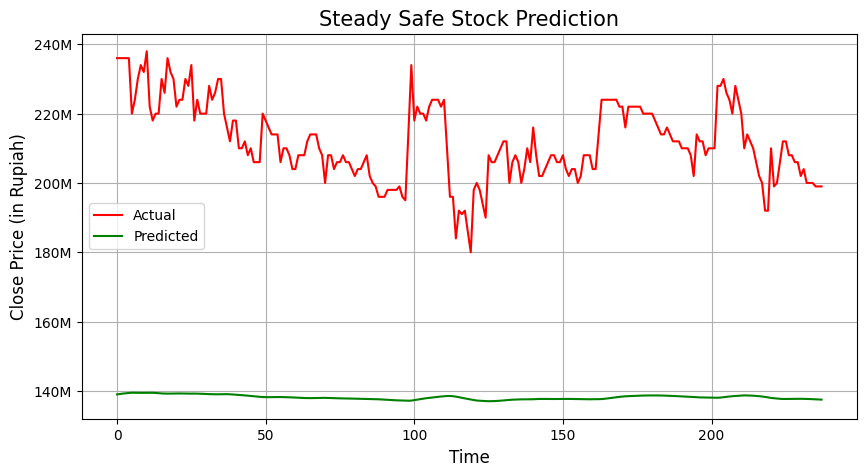

In [61]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_sigmoid_adagrad.h5')

##### Sigmoid - Nadam

In [62]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 23s 529ms/step - loss: 0.0293 - val_loss: 0.0034
Epoch 2/10
24/24 [==============================] - 11s 447ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 3/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 4/10
24/24 [==============================] - 10s 436ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 10s 433ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 6/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 7/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 8/10
24/24 [==============================] - 10s 430ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 9/10
24/24 [==============================] - 11s 446ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 10/10
24/24 [==============================] - 11s 442ms/step - loss: 0.0018 - val_lo

In [63]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Percentage Error (MAPE):  0.04333
Mean Absolute Error (MAE):  0.0171257
Mean Squared Error (MSE):  0.0005227
Root Mean Squared Error (RMSE):  0.02286
R-Squared:  0.481647


8/8 [==============================] - 0s 48ms/step


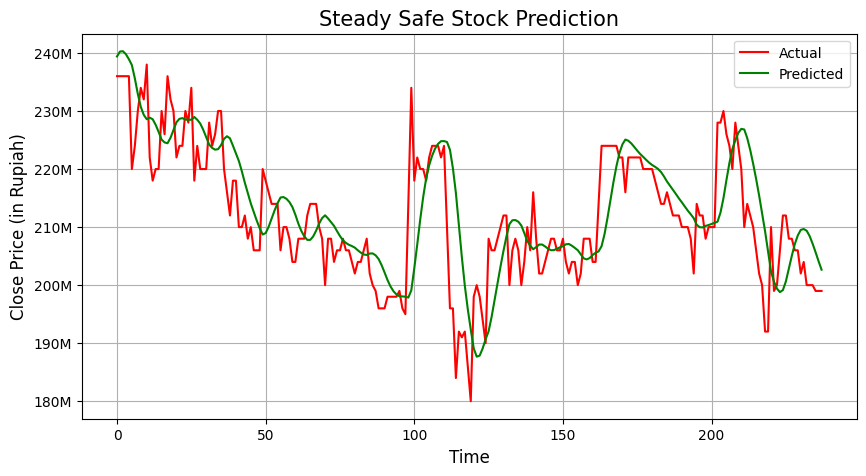

In [64]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_sigmoid_nadam.h5')

##### Sigmoid - RMSProp

In [65]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 19s 508ms/step - loss: 0.2035 - val_loss: 0.0793
Epoch 2/10
24/24 [==============================] - 11s 474ms/step - loss: 0.0275 - val_loss: 0.0039
Epoch 3/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0225 - val_loss: 0.0060
Epoch 4/10
24/24 [==============================] - 12s 480ms/step - loss: 0.0164 - val_loss: 0.0069
Epoch 5/10
24/24 [==============================] - 11s 461ms/step - loss: 0.0127 - val_loss: 0.0080
Epoch 6/10
24/24 [==============================] - 11s 462ms/step - loss: 0.0135 - val_loss: 0.0059
Epoch 7/10
24/24 [==============================] - 11s 455ms/step - loss: 0.0110 - val_loss: 0.0039
Epoch 8/10
24/24 [==============================] - 11s 469ms/step - loss: 0.0109 - val_loss: 0.0039
Epoch 9/10
24/24 [==============================] - 11s 463ms/step - loss: 0.0103 - val_loss: 0.0032
Epoch 10/10
24/24 [==============================] - 12s 490ms/step - loss: 0.0085 - val_lo

In [66]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 50ms/step
Mean Absolute Percentage Error (MAPE):  0.10864
Mean Absolute Error (MAE):  0.0442991
Mean Squared Error (MSE):  0.002423
Root Mean Squared Error (RMSE):  0.04922
R-Squared:  -1.402992


8/8 [==============================] - 0s 48ms/step


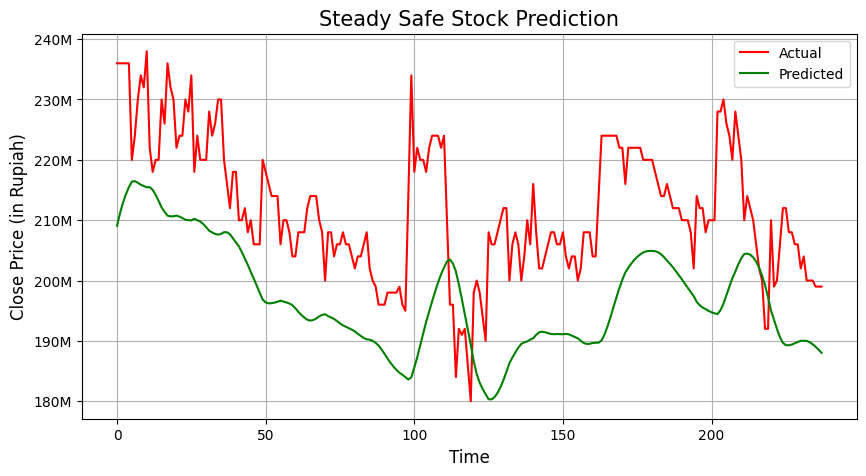

In [67]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_sigmoid_rmsprop.h5')

##### Sigmoid - AdaDelta

In [68]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 464ms/step - loss: 0.0610 - val_loss: 0.0812
Epoch 2/10
24/24 [==============================] - 10s 415ms/step - loss: 0.0606 - val_loss: 0.0806
Epoch 3/10
24/24 [==============================] - 10s 409ms/step - loss: 0.0602 - val_loss: 0.0800
Epoch 4/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0598 - val_loss: 0.0793
Epoch 5/10
24/24 [==============================] - 11s 459ms/step - loss: 0.0596 - val_loss: 0.0787
Epoch 6/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0591 - val_loss: 0.0780
Epoch 7/10
24/24 [==============================] - 10s 412ms/step - loss: 0.0587 - val_loss: 0.0774
Epoch 8/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0585 - val_loss: 0.0767
Epoch 9/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0580 - val_loss: 0.0761
Epoch 10/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0577 - val_lo

In [69]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 48ms/step
Mean Absolute Percentage Error (MAPE):  0.72564
Mean Absolute Error (MAE):  0.2920137
Mean Squared Error (MSE):  0.0862831
Root Mean Squared Error (RMSE):  0.29374
R-Squared:  -84.569607


8/8 [==============================] - 0s 47ms/step


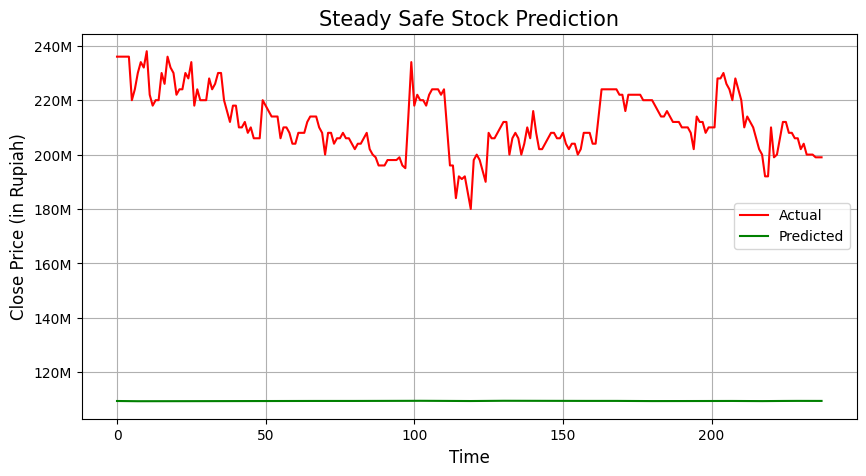

In [70]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_sigmoid_adadelta.h5')

##### Sigmoid - SGD

In [71]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 19s 493ms/step - loss: 0.0586 - val_loss: 0.0207
Epoch 2/10
24/24 [==============================] - 10s 417ms/step - loss: 0.0371 - val_loss: 0.0218
Epoch 3/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0364 - val_loss: 0.0194
Epoch 4/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0357 - val_loss: 0.0204
Epoch 5/10
24/24 [==============================] - 11s 461ms/step - loss: 0.0352 - val_loss: 0.0202
Epoch 6/10
24/24 [==============================] - 11s 466ms/step - loss: 0.0345 - val_loss: 0.0203
Epoch 7/10
24/24 [==============================] - 11s 469ms/step - loss: 0.0337 - val_loss: 0.0183
Epoch 8/10
24/24 [==============================] - 11s 478ms/step - loss: 0.0331 - val_loss: 0.0179
Epoch 9/10
24/24 [==============================] - 12s 484ms/step - loss: 0.0324 - val_loss: 0.0175
Epoch 10/10
24/24 [==============================] - 11s 474ms/step - loss: 0.0317 - val_lo

In [72]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 58ms/step
Mean Absolute Percentage Error (MAPE):  0.32404
Mean Absolute Error (MAE):  0.1316528
Mean Squared Error (MSE):  0.0182371
Root Mean Squared Error (RMSE):  0.13504
R-Squared:  -17.08627


8/8 [==============================] - 0s 57ms/step


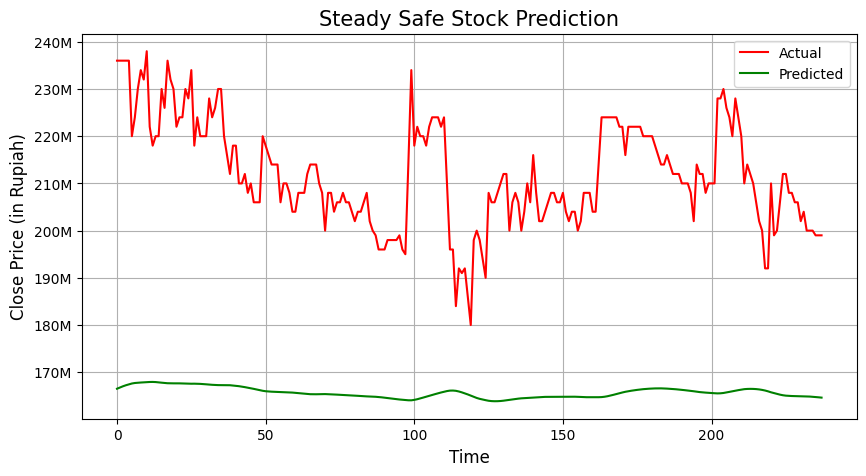

In [73]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_sigmoid_sgd.h5')

##### Sigmoid - Adamax

In [74]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 22s 522ms/step - loss: 0.0518 - val_loss: 0.0096
Epoch 2/10
24/24 [==============================] - 10s 426ms/step - loss: 0.0067 - val_loss: 0.0035
Epoch 3/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 4/10
24/24 [==============================] - 10s 406ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 5/10
24/24 [==============================] - 11s 446ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 6/10
24/24 [==============================] - 10s 426ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 9s 389ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 8/10
24/24 [==============================] - 9s 386ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 9/10
24/24 [==============================] - 9s 384ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 10/10
24/24 [==============================] - 10s 421ms/step - loss: 0.0029 - val_loss:

In [75]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 49ms/step
Mean Absolute Percentage Error (MAPE):  0.05078
Mean Absolute Error (MAE):  0.0203384
Mean Squared Error (MSE):  0.0008135
Root Mean Squared Error (RMSE):  0.02852
R-Squared:  0.193235


8/8 [==============================] - 0s 46ms/step


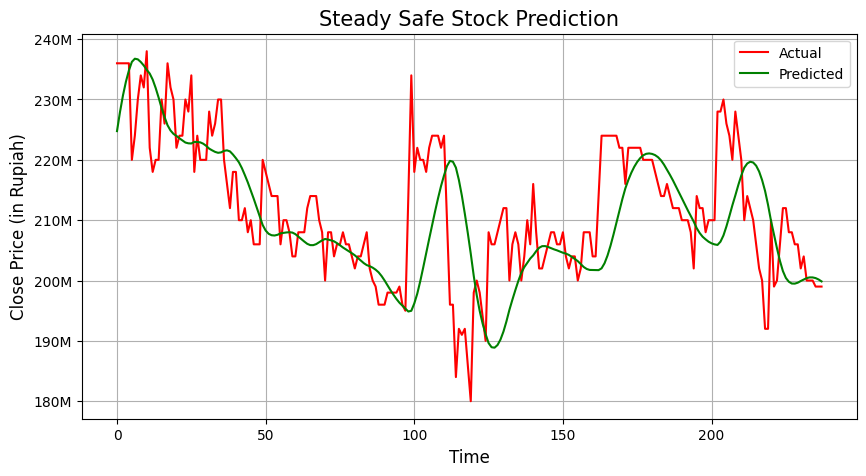

In [76]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_sigmoid_adamax.h5')

##### Tanh - Adam

In [77]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 20s 476ms/step - loss: 0.0127 - val_loss: 0.0035
Epoch 2/10
24/24 [==============================] - 10s 397ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 3/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 4/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 5/10
24/24 [==============================] - 11s 476ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 6/10
24/24 [==============================] - 10s 433ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 10s 430ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 10s 410ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 10s 410ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 10/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0019 - val_lo

In [78]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 46ms/step
Mean Absolute Percentage Error (MAPE):  0.03889
Mean Absolute Error (MAE):  0.015486
Mean Squared Error (MSE):  0.0004746
Root Mean Squared Error (RMSE):  0.02179
R-Squared:  0.529356


8/8 [==============================] - 0s 48ms/step


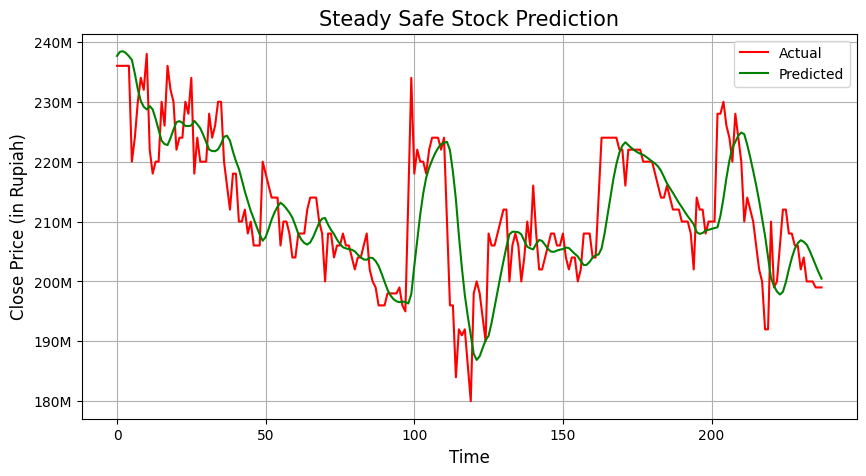

In [79]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_tanh_adam.h5')

##### Tanh - AdaGrad

In [80]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 19s 507ms/step - loss: 0.0866 - val_loss: 0.0812
Epoch 2/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0545 - val_loss: 0.0492
Epoch 3/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0439 - val_loss: 0.0341
Epoch 4/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0388 - val_loss: 0.0261
Epoch 5/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0360 - val_loss: 0.0219
Epoch 6/10
24/24 [==============================] - 11s 444ms/step - loss: 0.0339 - val_loss: 0.0192
Epoch 7/10
24/24 [==============================] - 11s 445ms/step - loss: 0.0325 - val_loss: 0.0175
Epoch 8/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0306 - val_loss: 0.0162
Epoch 9/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0294 - val_loss: 0.0152
Epoch 10/10
24/24 [==============================] - 11s 446ms/step - loss: 0.0283 - val_lo

In [81]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 47ms/step
Mean Absolute Percentage Error (MAPE):  0.29238
Mean Absolute Error (MAE):  0.1189443
Mean Squared Error (MSE):  0.0150015
Root Mean Squared Error (RMSE):  0.12248
R-Squared:  -13.877473


8/8 [==============================] - 0s 49ms/step


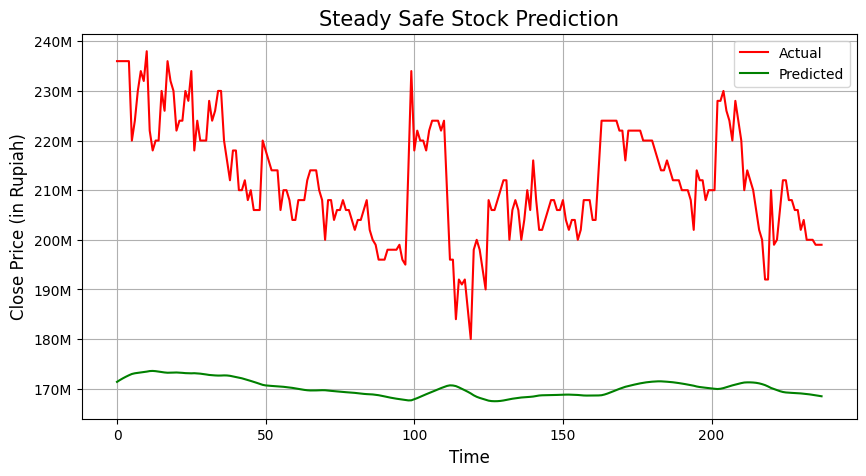

In [82]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_tanh_adagrad.h5')

##### Tanh - Nadam

In [83]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 21s 473ms/step - loss: 0.0105 - val_loss: 0.0031
Epoch 2/10
24/24 [==============================] - 10s 419ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 3/10
24/24 [==============================] - 10s 413ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 10s 412ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 5/10
24/24 [==============================] - 10s 408ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 6/10
24/24 [==============================] - 10s 427ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 7/10
24/24 [==============================] - 10s 420ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 11s 464ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 10/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0017 - val_lo

In [84]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Percentage Error (MAPE):  0.0437
Mean Absolute Error (MAE):  0.0172425
Mean Squared Error (MSE):  0.0004976
Root Mean Squared Error (RMSE):  0.02231
R-Squared:  0.506562


8/8 [==============================] - 0s 43ms/step


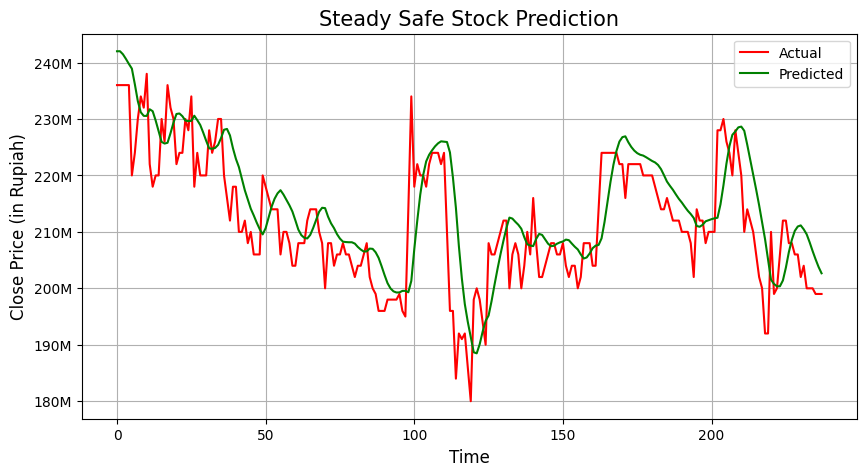

In [85]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_tanh_nadam.h5')

##### Tanh - RMSProp

In [86]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 445ms/step - loss: 0.0097 - val_loss: 0.0030
Epoch 2/10
24/24 [==============================] - 9s 358ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 3/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 4/10
24/24 [==============================] - 10s 407ms/step - loss: 0.0034 - val_loss: 0.0069
Epoch 5/10
24/24 [==============================] - 10s 422ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/10
24/24 [==============================] - 10s 408ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 10s 411ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 8/10
24/24 [==============================] - 9s 373ms/step - loss: 0.0025 - val_loss: 0.0065
Epoch 9/10
24/24 [==============================] - 9s 370ms/step - loss: 0.0024 - val_loss: 0.0057
Epoch 10/10
24/24 [==============================] - 10s 402ms/step - loss: 0.0024 - val_loss: 

In [87]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 3s 58ms/step
Mean Absolute Percentage Error (MAPE):  0.08596
Mean Absolute Error (MAE):  0.0337167
Mean Squared Error (MSE):  0.0014987
Root Mean Squared Error (RMSE):  0.03871
R-Squared:  -0.486316


8/8 [==============================] - 0s 55ms/step


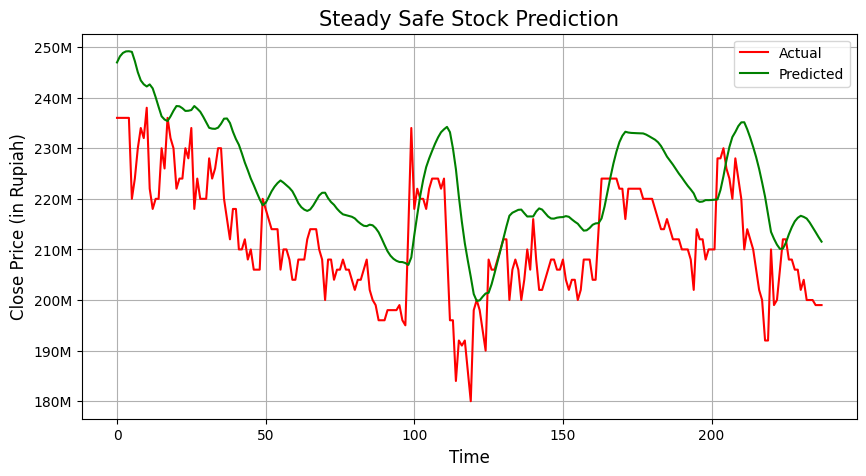

In [88]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_tanh_rmsprop.h5')

##### Tanh - AdaDelta

In [89]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 410ms/step - loss: 0.1363 - val_loss: 0.1989
Epoch 2/10
24/24 [==============================] - 8s 331ms/step - loss: 0.1349 - val_loss: 0.1963
Epoch 3/10
24/24 [==============================] - 8s 351ms/step - loss: 0.1324 - val_loss: 0.1936
Epoch 4/10
24/24 [==============================] - 8s 329ms/step - loss: 0.1309 - val_loss: 0.1910
Epoch 5/10
24/24 [==============================] - 8s 340ms/step - loss: 0.1292 - val_loss: 0.1883
Epoch 6/10
24/24 [==============================] - 8s 350ms/step - loss: 0.1273 - val_loss: 0.1856
Epoch 7/10
24/24 [==============================] - 8s 320ms/step - loss: 0.1260 - val_loss: 0.1828
Epoch 8/10
24/24 [==============================] - 8s 318ms/step - loss: 0.1235 - val_loss: 0.1801
Epoch 9/10
24/24 [==============================] - 8s 324ms/step - loss: 0.1218 - val_loss: 0.1773
Epoch 10/10
24/24 [==============================] - 8s 330ms/step - loss: 0.1199 - val_loss: 0.174

In [90]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 44ms/step
Mean Absolute Percentage Error (MAPE):  1.10129
Mean Absolute Error (MAE):  0.4420809
Mean Squared Error (MSE):  0.1966228
Root Mean Squared Error (RMSE):  0.44342
R-Squared:  -193.996965


8/8 [==============================] - 0s 48ms/step


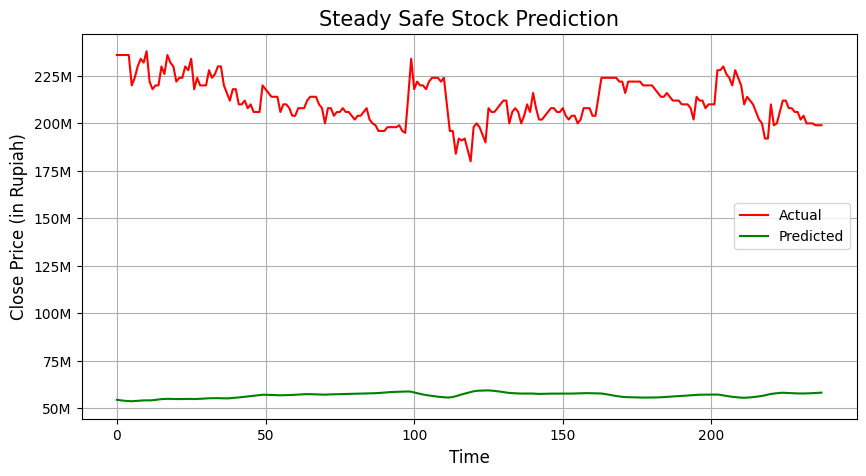

In [91]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_tanh_adadelta.h5')

##### Tanh - SGD

In [92]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 426ms/step - loss: 0.0583 - val_loss: 0.0271
Epoch 2/10
24/24 [==============================] - 8s 335ms/step - loss: 0.0389 - val_loss: 0.0199
Epoch 3/10
24/24 [==============================] - 7s 296ms/step - loss: 0.0341 - val_loss: 0.0179
Epoch 4/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0300 - val_loss: 0.0163
Epoch 5/10
24/24 [==============================] - 7s 286ms/step - loss: 0.0260 - val_loss: 0.0141
Epoch 6/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0223 - val_loss: 0.0113
Epoch 7/10
24/24 [==============================] - 7s 299ms/step - loss: 0.0189 - val_loss: 0.0107
Epoch 8/10
24/24 [==============================] - 7s 301ms/step - loss: 0.0158 - val_loss: 0.0088
Epoch 9/10
24/24 [==============================] - 7s 300ms/step - loss: 0.0131 - val_loss: 0.0073
Epoch 10/10
24/24 [==============================] - 7s 310ms/step - loss: 0.0112 - val_loss: 0.006

In [93]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 4s 56ms/step
Mean Absolute Percentage Error (MAPE):  0.14403
Mean Absolute Error (MAE):  0.0592313
Mean Squared Error (MSE):  0.0041391
Root Mean Squared Error (RMSE):  0.06434
R-Squared:  -3.104876


8/8 [==============================] - 0s 48ms/step


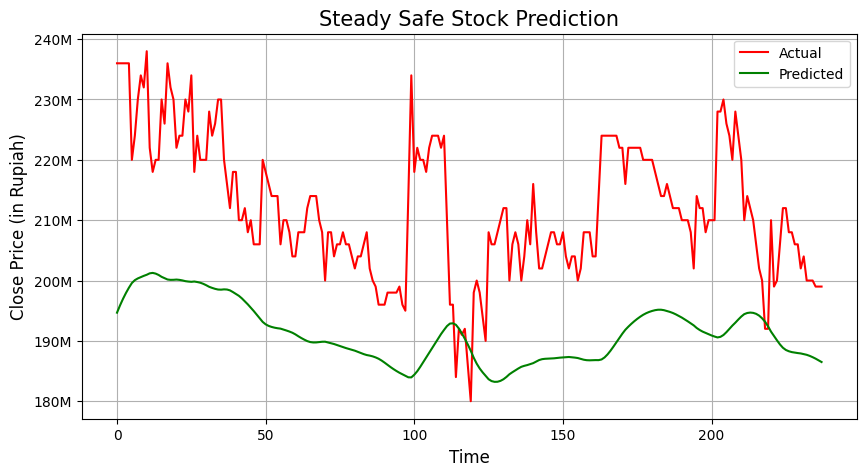

In [94]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_tanh_sgd.h5')

##### Tanh - Adamax

In [95]:
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()

Epoch 1/10
24/24 [==============================] - 18s 413ms/step - loss: 0.0119 - val_loss: 0.0034
Epoch 2/10
24/24 [==============================] - 8s 336ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 3/10
24/24 [==============================] - 8s 323ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 8s 335ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 5/10
24/24 [==============================] - 8s 322ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 6/10
24/24 [==============================] - 8s 322ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 7/10
24/24 [==============================] - 8s 336ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 8/10
24/24 [==============================] - 8s 321ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 9/10
24/24 [==============================] - 8s 323ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 10/10
24/24 [==============================] - 8s 326ms/step - loss: 0.0025 - val_loss: 0.002

In [96]:
# Check evaluation metrics
y_pred = model.predict(X_test)
mape = round(metrics.mean_absolute_percentage_error(y_test, y_pred), 5)
mae = round(metrics.mean_absolute_error(y_test, y_pred), 7)
mse = round(metrics.mean_squared_error(y_test, y_pred), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, y_pred), 6)
print('Mean Absolute Percentage Error (MAPE): ', mape)
print('Mean Absolute Error (MAE): ', mae)
print('Mean Squared Error (MSE): ', mse)
print('Root Mean Squared Error (RMSE): ', rmse)
print('R-Squared: ', r2)

8/8 [==============================] - 2s 48ms/step
Mean Absolute Percentage Error (MAPE):  0.0442
Mean Absolute Error (MAE):  0.0176057
Mean Squared Error (MSE):  0.0005925
Root Mean Squared Error (RMSE):  0.02434
R-Squared:  0.412411


8/8 [==============================] - 0s 43ms/step


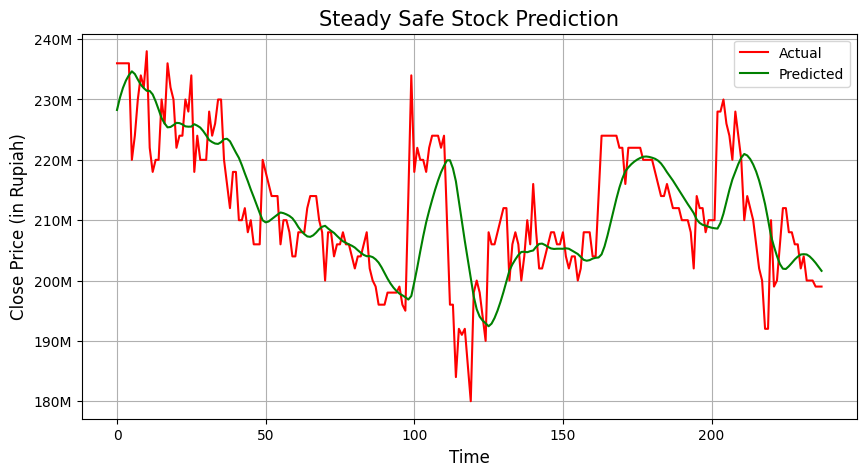

In [97]:
# Generate predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# Invert scaling for predictions
train_predict = scaler.inverse_transform(train_predict)
train_actual = scaler.inverse_transform(y_train)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(y_test)

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# plot testing actual vs predicted values
plt.figure(figsize=(10,5))
plt.plot(test_actual, label='Actual', color='red')
plt.plot(test_predict, label='Predicted', color='green')
plt.title('Steady Safe Stock Prediction', fontsize=15)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()
# Save the default model
model.save('models/safe_tanh_adamax.h5')

##### Comparison LSTM Model based on Activation and Optimizer Parameter

In [98]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 39ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 43ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 42ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 50ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 3s 58ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 51ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 47ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 45ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 47ms/step
Training

In [99]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta               123.32  0.35697   0.88867  0.12837   
           adagrad                 83.26  0.11225   0.27573  0.01342   
           adam                    83.77  0.01889   0.04806  0.00059   
           adamax                 131.16  0.02077   0.05311  0.00074   
           nadam                  101.46  0.01696   0.04291  0.00052   
           rmsprop                126.00  0.02336   0.05981  0.00082   
           sgd                    128.20  0.04048   0.09821  0.00212   
relu       adadelta                87.68  0.39322   0.97927  0.15564   
           adagrad                110.24  0.10746   0.26400  0.01231   
           adam                   109.88  0.02421   0.05953  0.00090   
           adamax                  87.89  0.01839   0.04594  0.00066   
           nadam                  122.54  0.01645   0.04105  0.00054   
           rmsprop                 91.64  0.04380   0.10762  0.00234   
           sgd                     78.09  0.05736   0.13964  0.00388   
sigmoid    adadelta                78.18  1.24157   3.10569  1.54251   
           adagrad                 86.26  0.80725   2.01755  0.65253   
           adam                    78.96  0.01798   0.04463  0.00061   
           adamax                  82.26  0.01953   0.04901  0.00076   
           nadam                   92.79  0.01816   0.04585  0.00063   
           rmsprop                 85.10  0.04598   0.11757  0.00266   
           sgd                     80.85  0.16312   0.40270  0.02758   
tanh       adadelta                81.04  0.36490   0.90854  0.13410   
           adagrad                 81.19  0.08355   0.20450  0.00765   
           adam                    89.23  0.02138   0.05443  0.00070   
           adamax                  80.63  0.01765   0.04437  0.00060   
           nadam                   84.31  0.01530   0.03821  0.00047   
           rmsprop                 92.34  0.05561   0.14111  0.00357   
           sgd                     86.32  0.03253   0.07869  0.00154   

                      R-Squared (%)  RMSE (%)  
Activation Optimizer                           
linear     adadelta         -126.31   0.35829  
           adagrad           -12.31   0.11584  
           adam                0.42   0.02429  
           adamax              0.26   0.02720  
           nadam               0.49   0.02280  
           rmsprop             0.19   0.02864  
           sgd                -1.11   0.04604  
relu       adadelta         -153.36   0.39451  
           adagrad           -11.21   0.11095  
           adam                0.11   0.03000  
           adamax              0.34   0.02569  
           nadam               0.46   0.02324  
           rmsprop            -1.32   0.04837  
           sgd                -2.84   0.06229  
sigmoid    adadelta        -1528.75   1.24198  
           adagrad          -646.13   0.80779  
           adam                0.40   0.02470  
           adamax              0.24   0.02757  
           nadam               0.37   0.02510  
           rmsprop            -1.64   0.05158  
           sgd               -26.35   0.16607  
tanh       adadelta         -131.99   0.36620  
           adagrad            -6.59   0.08746  
           adam                0.30   0.02646  
           adamax              0.40   0.02449  
           nadam               0.53   0.02168  
           rmsprop            -2.54   0.05975  
           sgd                -0.53   0.03924

In [100]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)'], 
                                 index=['Activation', 'Optimizer'])

# Calculate t-statistics and p-values for each performance metric
for col in ['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)']:
    t_stat, p_val = stats.ttest_1samp(df_result[col], 0.05)
    new_col_name_tstat = '{} (t-Statistic)'.format(col)
    new_col_name_pval = '{} (p-Value)'.format(col)
    df_pivot_result[new_col_name_tstat] = round(t_stat, 5)
    df_pivot_result[new_col_name_pval] = round(p_val, 5)

# Print the resulting pivot table with the horizontal t-statistic and p-value columns
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
tanh       nadam                   84.31  0.01530   0.03821  0.00047   
relu       nadam                  122.54  0.01645   0.04105  0.00054   
linear     nadam                  101.46  0.01696   0.04291  0.00052   
tanh       adamax                  80.63  0.01765   0.04437  0.00060   
sigmoid    adam                    78.96  0.01798   0.04463  0.00061   
           nadam                   92.79  0.01816   0.04585  0.00063   
relu       adamax                  87.89  0.01839   0.04594  0.00066   
linear     adam                    83.77  0.01889   0.04806  0.00059   
sigmoid    adamax                  82.26  0.01953   0.04901  0.00076   
linear     adamax                 131.16  0.02077   0.05311  0.00074   
tanh       adam                    89.23  0.02138   0.05443  0.00070   
relu       adam                   109.88  0.02421   0.05953  0.00090   
linear     rmsprop                126.00  0.02336   0.05981  0.00082   
tanh       sgd                     86.32  0.03253   0.07869  0.00154   
linear     sgd                    128.20  0.04048   0.09821  0.00212   
relu       rmsprop                 91.64  0.04380   0.10762  0.00234   
sigmoid    rmsprop                 85.10  0.04598   0.11757  0.00266   
relu       sgd                     78.09  0.05736   0.13964  0.00388   
tanh       rmsprop                 92.34  0.05561   0.14111  0.00357   
           adagrad                 81.19  0.08355   0.20450  0.00765   
relu       adagrad                110.24  0.10746   0.26400  0.01231   
linear     adagrad                 83.26  0.11225   0.27573  0.01342   
sigmoid    sgd                     80.85  0.16312   0.40270  0.02758   
linear     adadelta               123.32  0.35697   0.88867  0.12837   
tanh       adadelta                81.04  0.36490   0.90854  0.13410   
relu       adadelta                87.68  0.39322   0.97927  0.15564   
sigmoid    adagrad                 86.26  0.80725   2.01755  0.65253   
           adadelta                78.18  1.24157   3.10569  1.54251   

                      R-Squared (%)  RMSE (%)  MAPE (%) (t-Statistic)  \
Activation Optimizer                                                    
tanh       nadam               0.53   0.02168                 2.44678   
relu       nadam               0.46   0.02324                 2.44678   
linear     nadam               0.49   0.02280                 2.44678   
tanh       adamax              0.40   0.02449                 2.44678   
sigmoid    adam                0.40   0.02470                 2.44678   
           nadam               0.37   0.02510                 2.44678   
relu       adamax              0.34   0.02569                 2.44678   
linear     adam                0.42   0.02429                 2.44678   
sigmoid    adamax              0.24   0.02757                 2.44678   
linear     adamax              0.26   0.02720                 2.44678   
tanh       adam                0.30   0.02646                 2.44678   
relu       adam                0.11   0.03000                 2.44678   
linear     rmsprop             0.19   0.02864                 2.44678   
tanh       sgd                -0.53   0.03924                 2.44678   
linear     sgd                -1.11   0.04604                 2.44678   
relu       rmsprop            -1.32   0.04837                 2.44678   
sigmoid    rmsprop            -1.64   0.05158                 2.44678   
relu       sgd                -2.84   0.06229                 2.44678   
tanh       rmsprop            -2.54   0.05975                 2.44678   
           adagrad            -6.59   0.08746                 2.44678   
relu       adagrad           -11.21   0.11095                 2.44678   
linear     adagrad           -12.31   0.11584                 2.44678   
sigmoid    sgd               -26.35   0.16607                 2.44678   
linear     adadelta         -126.31 

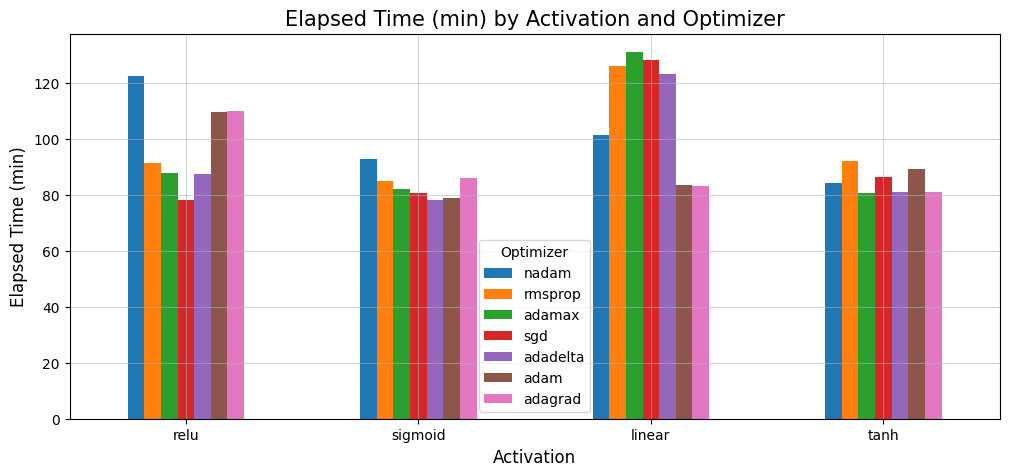

In [101]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

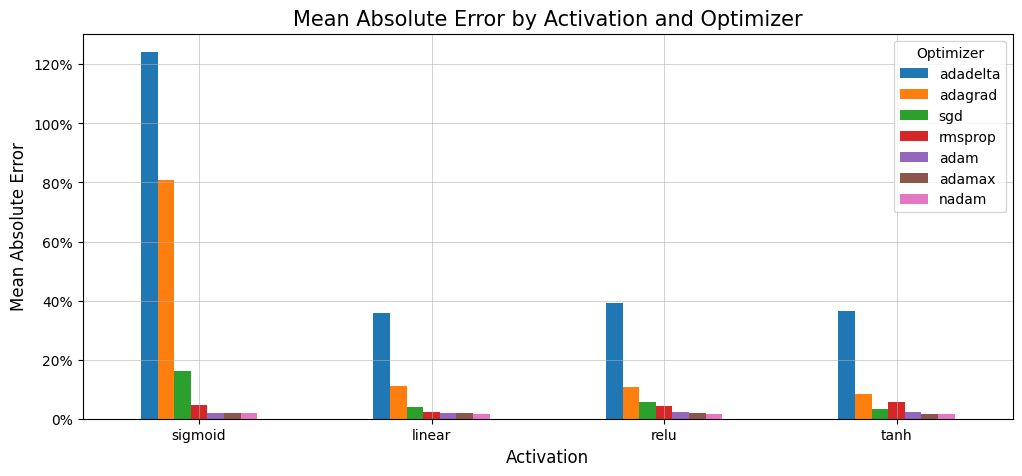

In [102]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

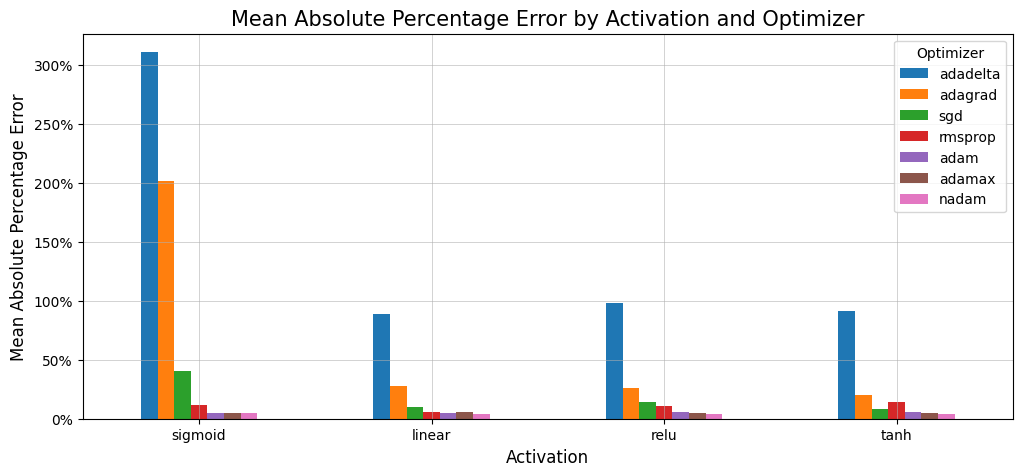

In [103]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

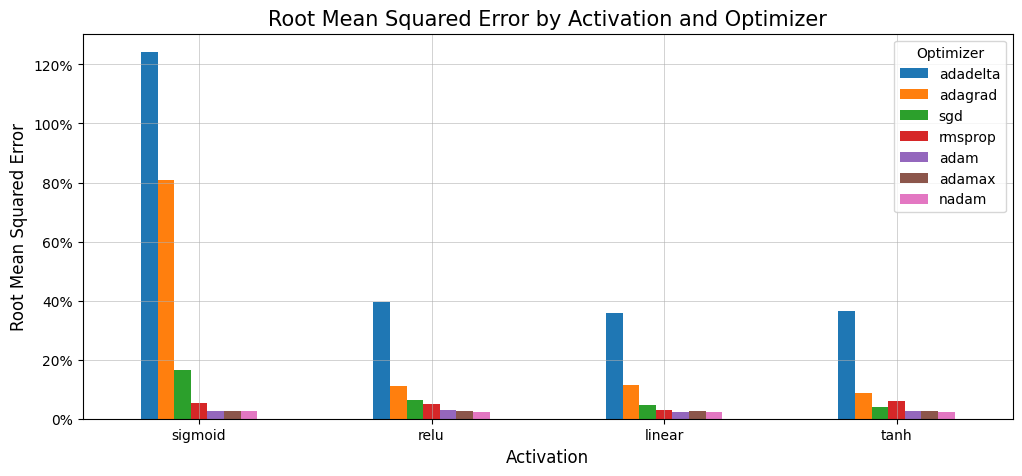

In [104]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

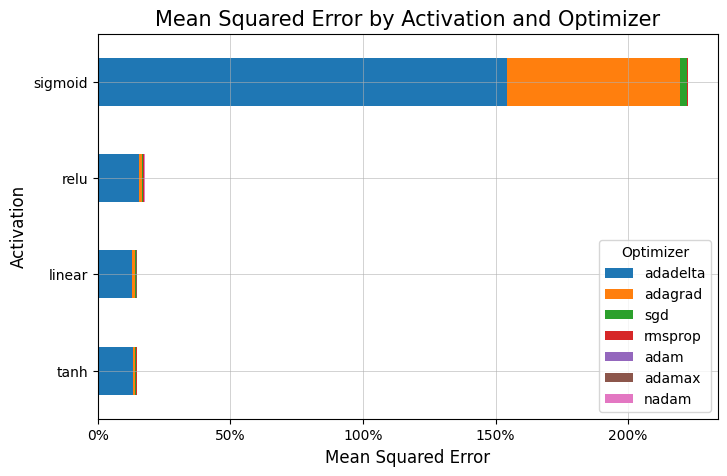

In [105]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean RMSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=True)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_mse.plot(kind='barh', stacked=True, ax=ax) # modified line
ax.set_xlabel('Mean Squared Error', fontsize=12)
ax.set_ylabel('Activation', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter) # modified line
ax.grid(True, linewidth='0.4')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0) # modified line
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

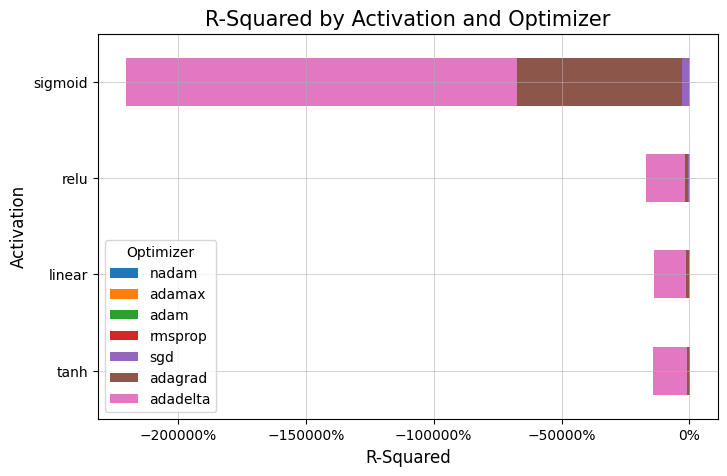

In [106]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean RMSE value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', stacked=True, ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()